In [2]:
library(reshape2)
library(tibble)
library(igraph)
library(xtable)

## Plotting
library(RColorBrewer)
library(ggplot2)
library(cowplot)
# library(rgl)
library(pROC)

# library(pheatmap)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)
# library(repr)
# options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())

## Custom
source("../functions.R")


Attaching package: ‘igraph’

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
# FUNCTIONS ---------------------------------------------------------------
#' @param y_true numeric vector of true labels with 1 as positive
calc_recall <- function(y_true, y_pred) {
  sum(y_pred[y_true == 1] == 1) / sum(y_true == 1)
}
#' @param y_true numeric vector of true labels with 1 as positive
calc_specificity <- function(y_true, y_pred) {
  sum(y_pred[y_true == 0] == 0) / sum(y_true == 0)
} 

#' Sorts sample IDs so that they are paired
sort_sid <- function(x) {
  pid <- sapply(x, substring, 1, 4)
  time <- sapply(x, substring, 6, 7)
  time_pid <- mapply(paste0, time, pid)
  return(x[order(time_pid)])
}

#' Boolean function checking that dataframe provided has matching pair names
#' @param X dataframe with paired samples
#' @return logical indicating if it is paired or not
is_paired <- function(X) {
  n <- ncol(X)
  sid_substr <- substring(colnames(X), 1, 4)
  all(sid_substr[1:(n / 2)] == sid_substr[(n / 2 + 1):n])
}

plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# Selecting drug responsive genes between D0 and D8
# using paired t-test and logfc
selectFeatures <- function(df1, metadata_df,
                           alpha = 0.05, logfc_threshold = 1) {
  # Subset df according to D0 and D8
  class_info <- metadata_df[colnames(df1), "class_info"]
  df_d0 <- df1[,class_info == "D0"]
  df_d8 <- df1[,class_info == "D8"]
  print(head(colnames(df_d0)))
  print(head(colnames(df_d8)))
  stopifnot(ncol(df_d0) == ncol(df_d8))
  
  # Identify drug responsive probesets
  ttest_pvalue <- calc_ttest(cbind(df_d0, df_d8), ncol(df_d0), is_paired = T)
  log_fc <- rowMeans(df_d8) - rowMeans(df_d0)
  ttest_probesets <- names(ttest_pvalue)[ttest_pvalue <= alpha]
  fc_probesets <- names(log_fc)[log_fc > logfc_threshold]
  intersect_probesets <- intersect(ttest_probesets, fc_probesets)
  print(paste("T-test:", length(ttest_probesets)))
  print(paste("Log fold change:", length(fc_probesets)))
  print(paste("Intersection:", length(intersect_probesets)))
  return(intersect_probesets)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

plotJitterYeoh <- function(X, metadata_df, n_pc = 10) {
  pca_obj <- prcomp(t(X))
  X_pca <- data.frame(pca_obj$x)
  batch <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class <- as.factor(metadata_df[rownames(X_pca),"class_info"])
  X_meta <- cbind(batch, class, X_pca[,1:n_pc])
  X_long <- melt(X_meta, id = c("batch", "class"), variable.name="PC")
  
  ax_batch <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=batch), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=batch), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  ax_class <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=class), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=class), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  fig <- plot_grid(ax_batch, ax_class, nrow = 2)
  return(fig)  
}

plotFeatures <- function(results, metadata_df) {
  y <- as.factor(metadata_df[rownames(results),"label"])
  subset_features1 <- c("erm1", "angle_d0d8_normal", "l2norm_d0_d8",
                        "l2norm_d0_normal", "l2norm_d8_normal", "l2norm_diff",
                        "erm1_ratio1", "erm1_ratio2", "erm1_ratio3",
                        "l2norm_ratio1", "l2norm_ratio2", "l2norm_diff_ratio")
  
  features1 <- results[, subset_features1, drop=F]
  features1_y <- data.frame(features1, label = y)
  long_features1_y <- melt(features1_y, id="label", variable.name = "feature")
  
  # PLOT: FEATURES
  jitter_features1 <- ggplot(long_features1_y) +
    geom_point(aes(feature, value, colour = label),
               position = position_jitterdodge(), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 2, ncol = 6,  scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
  
  return(jitter_features1)
}

# Factor to split data
splitSubtype <- function(X, metadata_df) {
  if (!is(X, "data.frame"))
    X <- data.frame(X)
  
  subtype_factor <- as.factor(metadata_df[colnames(X), "subtype"])
  split.default(X, subtype_factor, drop = F) # Split by subtype
}

## Import data

In [4]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [14]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

sid_remission <- rownames(Y)[Y$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))
subtypes1 <- setdiff(subtypes, c("Hyperdiploid", "Others"))

In [6]:
## Define train/test split
sid_train1 <- rownames(Y)[
  Y$batch_info %in% 1:5 &
  Y$class_info != "N" &
  Y$subtype != "Hypodiploid"
]
sid_test1 <- rownames(Y)[
  Y$batch_info %in% 6:10 &
  Y$class_info != "N" &
  Y$subtype != "Hypodiploid"
]

sid_train2 <- rownames(Y)[
  Y$batch_info %in% 1:5 & Y$class_info != "N" &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others"))
]
sid_test2 <- rownames(Y)[
  Y$batch_info %in% 6:10 & Y$class_info != "N" &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others"))
]

# There is only 1 MLL patient (CCR) in training set if data was split by batch
mll_patient <- c("P160_D0", "P160_D8")
sid_train1a <- sort_sid(union(sid_train1, mll_patient))
sid_test1a <- setdiff(sid_test1, mll_patient)

sid_train2a <- sort_sid(union(sid_train2, mll_patient))
sid_test2a <- setdiff(sid_test2, mll_patient)

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [7]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

#### Plot: UpSet

In [126]:
# list_batch_genes <- list(anova = batch_genes, welch = welch_genes,
#                          kruskal = kruskal_genes)

# upset(fromList(list_batch_genes),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-batch_genes.pdf",
#          width = 8, height = 8)

### Drug genes

Constant: Subtype, remission

In [8]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, sid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  if (!is_paired(X_subtype))
    stop("Patient IDs are not paired..")
  
  sid_idx <- intersect(sid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[, sid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission) / 2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  D0 <- X_subtype_remission[, 1:n_pairs, drop = F]
  D8 <- X_subtype_remission[, -(1:n_pairs), drop = F]
  
  # Median paired log-FC
  paired_logfc <- D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(D0)
  d8_mu <- rowMeans(D8)
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  feat <- intersect(feat_p, feat_log2fc)
  return(feat)
}

In [9]:
#' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
calcERM <- function(response_df, normal_df) {
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n, , drop = F]
  d8_df <- response_df[-(1:n), , drop = F]
  
  if (!is_paired(t(response_df)))
    stop("Patient IDs are not paired..")
  
  # Calculate centroids
  leuk_centroid <- apply(d0_df, 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)
}

In [10]:
#' ASSUMPTION: X_train is filtered of NA MRD values and contains all features!
#' @param X_train dataframe of training set (incl. MRD) with patients x features
#' @param Y dataframe of metadata with samples x info
#' @param bigpos_names vector of feature names where bigger is positive
#' @param smallpos_names vector of feature names where smaller is positive
#' @param X_test dataframe of test set (incl. MRD)
predict_plot <- function(X_train, Y,
                         bigpos_names,
                         smallpos_names,
                         X_test = NULL) {
  #' Calculate probability of remission as percentage of remission cases with
  #' scores that are worse than or equal to the current score
  #' @param X_train dataframe of training set (incl. MRD) with patients x features
  #' @param Y dataframe of metadata with samples x info
  #' @param bigpos_names vector of feature names where bigger is positive
  #' @param smallpos_names vector of feature names where smaller is positive
  #' @param X_predict dataframe containing samples to be predicted (incl. MRD)
  calc_p_remission <- function(X_train, Y,
                               bigpos_names,
                               smallpos_names,
                               X_predict) {
    #' Pct of remission cases with worse than or equal to the current score
    #' Bigger values indicate it being worse
    #' @param x vector of feature scores from diff samples
    #' @param x_remission vector of feature scores from relapse samples
    calc_pct_remission_x <- function(x, x_remission) {
      sapply(
        x,
        function(x_i) sum(x_i <= x_remission) / length(x_remission)
      )
    }
    
    #' Standardises features so that bigger values indicate positive label
    select_orientate_features <- function(X, bigpos_names, smallpos_names) {
      # Assumption: Either smallpos_names or bigpos_names will not be NULL
      if (is.null(smallpos_names)) {
        return(X[, bigpos_names, drop =  F])
      } else if (is.null(bigpos_names)) {
        # reverse order - bigger values now indicate relapse
        return(-X[, smallpos_names, drop =  F])
      } else {
        return(cbind(-X[, smallpos_names, drop =  F],
                     X[, bigpos_names, drop =  F]))
      }
    }

    X1_train <- select_orientate_features(X_train, bigpos_names, smallpos_names)
    idx <- paste0(rownames(X1_train), "_D0") # in order to access metadata
    Y1_train <- Y[idx, , drop = F]
    X1_train_remission <- X1_train[Y1_train$label == 0,]  # Only remission
    
    X1_predict <- select_orientate_features(X_predict, bigpos_names, smallpos_names)
    
    pct_remission <- mapply(calc_pct_remission_x,
                            data.frame(X1_predict),
                            data.frame(X1_train_remission))
    rownames(pct_remission) <- rownames(X1_predict)

    # Average p(remission|x)
    p <- apply(pct_remission, 1, mean, na.rm = T)
    p_wo <- apply(pct_remission, 1, mean, na.rm = T)
    
    label <- as.factor(
      Y[paste0(rownames(X1_predict), "_D0"), "label"]
    )
    
    p_remission <- data.frame(
      pid = rownames(pct_remission),
      label = label,
      p = p,
      p_wo = p_wo, # OPTION: DELETE WHEN PLOTTING
      pct_remission
    )
    
    return(p_remission)
  }
  
  # If test set is present, predict test set
  if (is.null(X_test)) {
    X_predict <- X_train
  } else {
    X_predict <- X_test
  }
  
  p_remission <- calc_p_remission(
    X_train, Y,
    bigpos_names,
    smallpos_names,
    X_predict
  )
  
  pred <- p_remission
  
  # Select features
  X_fltr_train <- X_train[, c(bigpos_names, smallpos_names)]
  X_fltr_predict <- X_predict[, c(bigpos_names, smallpos_names)]
  
  # Plot: Jitter - Features and risk_relapse
  COL_LABEL <- c("darkolivegreen3", "tomato3")
  
  X_y <- cbind(
    X_fltr_predict,
    p_rem = pred$p,
    label = pred$label
  )
  X_y$mrd <- log10(X_y$mrd) # log-transform  mrd
  colnames(X_y)[colnames(X_y) == "mrd"] <- "log_mrd"

  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
  
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_d0d8_d0normal", "log_mrd", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "paste('P(Remission|', bold(x), ')')"
  )
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  ) # Reorder levels
  
#   print(head(long_X_y))
#   print(levels(long_X_y$feature))
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    list_p_rem <- split(X_y$p_rem, X_y$label)
    
    try({
      ttest <- t.test(list_p_rem[[1]], list_p_rem[[2]])
      p_lab <- sprintf("p = %.3f", ttest$p.value)
      
      ann_text <- data.frame(
        feature = factor(
          FEAT_ORDER[5],
          levels = FEAT_ORDER,
          labels = FEAT_LABS
        ),
        value = Inf,
        lab =  p_lab
      )

      ax_jitter <- ax_jitter +
        geom_text(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  vjust = 3, hjust = -0.1)
      })
  }
  
  ## Plot: Parallel coordinates - Pct
  pred1 <- pred[, -which(colnames(pred) == "p_wo")]
  long_pred <- melt(pred1, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_pred,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: CDF
  emp_cdf <- ggplot(pred,
                    aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = COL_LABEL)
  
  ## PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- pred[order(pred$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
  
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
  
  ## Plot: ROC
  # ERM1 evaluated is not from global GSS model
  pred_x <- cbind(pred, erm = X_predict$erm1, d33_mrd = X_predict$mrd) # subset mrd
                                
  x_names <- c("p", "erm", "d33_mrd")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (length(table(pred_x$label)) > 1) {
    ax_roc <- plot_roc(pred_x, "label", x_names)
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                 ncol = 2, rel_widths = c(1.8, 1))
  } else{
    ax2 <- ax_parallel # unable to plot ROC
  }
  
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(pred_x) +
    geom_point(aes(p, log10(d33_mrd), colour = label),
               cex = 3, show.legend = F) +
    scale_color_manual(values = COL_LABEL)
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)
  
  list(
    p_rem = pred[, "p", drop = F],
    P = pred,
    X_y = X_y,
    plot = fig
  )
}

In [11]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_pipeline <- function(X_subtype, X_normal,
                             metadata, metadata_mrd,
                             batch_genes = NULL) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  if (!is_paired(X_subtype))
    stop("Patient IDs are not paired..")
  
  class_genes <- getLocalGenes(X_subtype, sid_remission)
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, ])
  normal <- t(X_normal[selected_genes, ])
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  V <- calcERM(response, normal)
  # Remove patients with NA MRD
  V1 <- V[!is.na(metadata_mrd[rownames(V), "d33_mrd"]), ]
  V1$mrd <- metadata_mrd[rownames(V1), "d33_mrd"]
  
  prediction_obj <- predict_plot(
    V1, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd")
  )
  
  return(prediction_obj)
}

### M1: Entire data

In [13]:
X_normal <- data[, rownames(Y)[Y$class_info == "N"]]
list_X_subtype1 <- lapply(
  subtypes,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj1 <- lapply(
  list_X_subtype1,
  predict_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)

## M1: Entire data (with Hyperdiploid, Others)
list_p1 <- lapply(list_obj1, function(obj) obj$p_rem)
p_train1 <- do.call(rbind, list_p1)

## M1: Entire data (homomgeneous only)
names(list_obj1) <- subtypes
list_obj2 <- list_obj1[subtypes1]
names(list_obj2) <- NULL # avoid funny row.names
list_p2 <- lapply(list_obj2, function(obj) obj$p_rem)
p_train2 <- do.call(rbind, list_p2)        

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of selected genes = " "80"                      
[1] "No. of final genes = " "66"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

In [444]:
# subtypes <- setdiff(levels(Y$subtype),
#                     c("Hypodiploid", "Normal", "Others"))
# subtypes1 <- subtypes
# print(subtypes)
subtypes1 <- setdiff(subtypes, c("Hyperdiploid", "Others"))

### M1: Train/test

In [15]:
#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
predict_pipeline_test <- function(X_subtype, X_normal,
                                  metadata, metadata_mrd,
                                  idx_global_train,
                                  idx_global_test,
                                  batch_genes) {
  sid_remission <- colnames(X_subtype)[
    metadata[colnames(X_subtype), "label"] == 0
  ]
  
  if (!is_paired(X_subtype))
    stop("Patient IDs are not paired..")
  
  sid_train <- intersect(colnames(X_subtype), idx_global_train)
  sid_test <- intersect(colnames(X_subtype), idx_global_test)
  
  X_train <- X_subtype[, sid_train, drop = F]
  X_test <- X_subtype[, sid_test, drop = F]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(X_train, sid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  response <- t(X_subtype[selected_genes, , drop = F])
  normal <- t(X_normal[selected_genes, , drop = F])
  
  print(rownames(response))
  print(rownames(normal))
  
  # Compute features on both train and test
  V <- calcERM(response, normal)
  
  # Remove patients with NA MRD
  V1 <- V[!is.na(metadata_mrd[rownames(V), "d33_mrd"]), ]
  V1$mrd <- metadata_mrd[rownames(V1), "d33_mrd"]
  
  pid_global_train <- unique(substring(idx_global_train, 1, 4))
  pid_global_test <- unique(substring(idx_global_test, 1, 4))
    
  pid_train <- intersect(rownames(V1), pid_global_train)
  pid_test <- intersect(rownames(V1), pid_global_test)
  
  V1_train <- V1[pid_train, , drop = F ]
  V1_test <- V1[pid_test, , drop = F ]
  
  prediction_obj <- predict_plot(
    V1_train, metadata,                             
    bigpos_names = "angle_d0d8_d0normal",
    smallpos_names = c("erm1_ratio2", "l2norm_ratio2", "mrd"),
    V1_test
  )
  
  return(prediction_obj)
}

### M1: Test set 1 (w Hyp, Others)

In [16]:
## Collate final prediction from each subtype
list_X_subtype1 <- lapply(
  subtypes,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj <- lapply(
  list_X_subtype1,
  predict_pipeline_test,
  X_normal, Y, yeoh_label,
  sid_train1a, sid_test1a,
  batch_genes
)
# list_p <- lapply(list_obj, function(obj) obj$p_rem)
# p_test1 <- do.call(rbind, list_p)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 766"
[1] "No. of features (p-value) = 132"
[1] "No. of features (log2-fc) = 314"
[1] "No. of class genes = " "14"                   
[1] "No. of selected genes = " "10"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
Error in t.test.default(list_p_rem[[1]], list_p_rem[[2]]) : 
  data are essentially constant


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1105"
[1] "No. of features (p-value) = 356"
[1] "No. of features (log2-fc) = 813"
[1] "No. of class genes = " "123"                  
[1] "No. of selected genes = " "79"                      
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 849"
[1] "No. of features (p-value) = 1162"
[1] "No. of features (log2-fc) = 252"
[1] "No. of class genes = " "206"                  
[1] "No. of selected genes = " "151"                     
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 384"
[1] "No. of features (p-value) = 459"
[1] "No. of features (log2-fc) = 1281"
[1] "No. of class genes = " "164"                  
[1] "No. of selected genes = " "109"                     
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 923"
[1] "No. of features (p-value) = 2492"
[1] "No. of features (log2-fc) = 530"
[1] "No. of class genes = " "518"                  
[1] "No. of selected genes = " "386"                     
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0"

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1217"
[1] "No. of features (p-value) = 402"
[1] "No. of features (log2-fc) = 339"
[1] "No. of class genes = " "76"                   
[1] "No. of selected genes = " "67"                      
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 886"
[1] "No. of features (p-value) = 1890"
[1] "No. of features (log2-fc) = 340"
[1] "No. of class genes = " "330"                  
[1] "No. of selected genes = " "239"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


### M1: Test set 1 (w/o Hyp, Others)

In [17]:
list_X_subtype2 <- lapply(
  subtypes1,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj2 <- lapply(
  list_X_subtype2,
  predict_pipeline_test,
  X_normal, Y, yeoh_label,
  sid_train2a, sid_test2a,
  batch_genes
)
list_p2 <- lapply(list_obj2, function(obj) obj$p_rem)
p_test2 <- do.call(rbind, list_p2)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 766"
[1] "No. of features (p-value) = 132"
[1] "No. of features (log2-fc) = 314"
[1] "No. of class genes = " "14"                   
[1] "No. of selected genes = " "10"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
Error in t.test.default(list_p_rem[[1]], list_p_rem[[2]]) : 
  data are essentially constant


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1105"
[1] "No. of features (p-value) = 356"
[1] "No. of features (log2-fc) = 813"
[1] "No. of class genes = " "123"                  
[1] "No. of selected genes = " "79"                      
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 384"
[1] "No. of features (p-value) = 459"
[1] "No. of features (log2-fc) = 1281"
[1] "No. of class genes = " "164"                  
[1] "No. of selected genes = " "109"                     
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1217"
[1] "No. of features (p-value) = 402"
[1] "No. of features (log2-fc) = 339"
[1] "No. of class genes = " "76"                   
[1] "No. of selected genes = " "67"                      
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 886"
[1] "No. of features (p-value) = 1890"
[1] "No. of features (log2-fc) = 340"
[1] "No. of class genes = " "330"                  
[1] "No. of selected genes = " "239"                     
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [479]:
# list_ax <- lapply(list_obj2, function(obj) obj$plot)
# i <- 1
# for (ax in list_ax) {
#   print(subtypes1[i])
#   wpath <- sprintf("~/Dropbox/temp/plot-%s.pdf", subtypes1[i])
#   ggsave(wpath, ax, width = 12, height = 6)
#   i <- i + 1
# }

[1] "BCR-ABL"
[1] "E2A-PBX1"
[1] "MLL"
[1] "T-ALL"
[1] "TEL-AML1"


### Yeoh (2018): Global ERM
- Feature selection: Top 1000 DE probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)
- Quantile normalisation does not improve results by much

### Global ERM: Train (w Hyper, Others)

In [18]:
### Yeoh (2018): Prediction
## Feature selection
sid_all <- rownames(Y)[!(Y$subtype %in% c("Hypodiploid", "Normal"))]
X <- data[, sid_all]
n <- ncol(X)
D0 <- X[, 1:(n / 2)]
D8 <- X[, (n / 2 + 1):n]

if (!is_paired(cbind(D0, D8)))
  stop("Patient IDs are not paired..")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(cbind(D0, D8)[ps_wilcox, ])
normal <- t(data[ps_wilcox, 403:405])
V <- calcERM(response, normal)
global_erm_train1 <- V[, "erm1", drop = F]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

### Global ERM: Train (w/o Hyper, Others)

In [20]:
### Yeoh (2018): Prediction
## Feature selection
excl_subtypes <- c("Hypodiploid", "Normal",
                   "Hyperdiploid", "Others")
sid_all <- rownames(Y)[!(Y$subtype %in% excl_subtypes)]
X <- data[, sid_all]
n <- ncol(X)
D0 <- X[, 1:(n / 2)]
D8 <- X[, (n / 2 + 1):n]

if (!is_paired(cbind(D0, D8)))
  stop("Patient IDs are not paired..")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(cbind(D0, D8)[ps_wilcox, ])
normal <- t(data[ps_wilcox, 403:405])
V <- calcERM(response, normal)
global_erm_train2 <- V[, "erm1", drop = F]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


### Global ERM: Test data 1 (w Hyp, Others)

In [21]:
### Yeoh (2018): Prediction
X_train <- data[, sid_train1a]  # Does not contain hypodiploid
n <- ncol(X_train)
D0_train <- X_train[, 1:(n / 2)]
D8_train <- X_train[, (n / 2 + 1):n]

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

if (!is_paired(cbind(D0_train, D8_train)))
  stop("Patient IDs are not paired..")
## Feature selection (on training set only)
wilcox_pvalue <- row_wilcox(D0_train, D8_train)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


In [22]:
response <- t(data[
  ps_wilcox, sort_sid(union(sid_train1a, sid_test1a))
])
normal <- t(data[ps_wilcox, 403:405])

V <- calcERM(response, normal)
global_erm_test1 <- V[
  unique(substring(sid_test1a, 1, 4)),
  "erm1", drop = F
]

### Global ERM: Test data 2 (wo Hyper, Others)

In [23]:
X_train <- data[, sid_train2a]
n <- ncol(X_train)
D0_train <- X_train[, 1:(n / 2)]
D8_train <- X_train[, (n / 2 + 1):n]

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

if (!is_paired(cbind(D0_train, D8_train)))
  stop("Patient IDs are not paired..")
## Feature selection (on training set only) without hyperdiploid, others!
wilcox_pvalue <- row_wilcox(D0_train, D8_train)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


In [24]:
response <- t(data[
  ps_wilcox, sort_sid(union(sid_train2a, sid_test2a))
])
normal <- t(data[ps_wilcox, 403:405])

V <- calcERM(response, normal)
global_erm_train2 <- V[
  unique(substring(sid_train2a, 1, 4)), # subset test samples
  "erm1", drop = F
]
global_erm_test2 <- V[
  unique(substring(sid_test2a, 1, 4)), # subset test samples
  "erm1", drop = F
]

## Plot: ROC

In [25]:
#' @param p dataframe of predictions from model M1
#' @param global_erm
combine_save_roc <- function(p, global_erm, metadata_mrd, wpath) {
  # Filter NA MRD values from ERM using colnames(p_test)
  erm_fltr <- global_erm[rownames(p), , drop = F]

  # Select MRD test set
  mrd_fltr <- metadata_mrd[rownames(p), "d33_mrd", drop = F]
  y_test <- metadata_mrd[rownames(p), "label"]
  
  eval_test <- cbind(p, erm_fltr, mrd_fltr, y_test)
  x_names <- c("M1", "ERM", "MRD")
  colnames(eval_test) <- c(x_names, "label")
  print(eval_test)
  
  ax_roc <- plot_roc(
    eval_test, "label",
    x_names,
    pauc.limits = c(1, .8)
  )
  ggsave(wpath, ax_roc, width = 5, height = 5)
  return(ax_roc)
}

### ROC (Test - w Hyperdiploid, Others)

In [565]:
# WPATH <- "~/Dropbox/temp/roc-m1_test1.pdf"
# eval_test1 <- combine_save_roc(
#   p_test1,
#   global_erm_test1,
#   yeoh_label,
#   c("M1", "ERM", "MRD"),
#   c(F, F, T), 
#   WPATH
# )

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


### ROC (Test - w/o Hyperdiploid, Others)

In [399]:
WPATH <- "~/Dropbox/temp/roc-m1_test2.pdf"
eval_test2 <- combine_save_roc(
  p_test2,
  global_erm_test2,
  yeoh_label,
  WPATH
)

            M1        ERM   MRD label
P134 0.2500000  17.385827 9e-02     1
P152 0.2500000   7.158131 3e-01     1
P170 0.1666667 -15.503875 2e-03     0
P175 0.1666667  53.306319 1e-04     0
P184 0.2500000   7.632490 1e+00     1
P102 0.1666667   7.621845 2e-02     1
P145 0.1666667  43.058111 1e-04     0
P161 0.3333333  63.363361 1e-04     0
P122 0.3750000  34.849578 2e-02     1
P131 0.2500000  26.263018 1e-02     1
P137 0.1250000  32.625903 3e-04     1
P167 0.0000000  54.312569 1e-04     1
P211 0.7500000  78.127197 2e-04     0
P103 0.3571429  15.475749 3e-02     0
P151 0.3571429  33.387828 2e-02     1
P099 0.9027778 100.222627 1e-04     0
P106 0.9305556 103.229546 1e-04     0
P120 0.7500000  72.572856 1e-04     0
P121 0.5277778  53.851320 1e-04     0
P127 0.7361111  87.535598 1e-04     0
P135 0.7777778  73.549198 1e-04     0
P136 0.6111111  48.093093 1e-04     1
P147 0.7916667  84.477346 1e-04     0
P156 0.6527778  65.070756 6e-04     0
P165 0.7083333  87.991134 1e-04     0
P166 0.75000

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in if (pauc.axis == "specificity") {:
“the condition has length > 1 and only the first element will be used”

### ROC (Train - w Hyperdiploid, Others)

In [567]:
# WPATH <- "~/Dropbox/temp/roc-m1_train1.pdf"
# eval_train1 <- combine_save_roc(
#   p_train1,
#   global_erm_train1,
#   yeoh_label,
#   c("M1", "ERM", "MRD"),
#   c(F, F, T),
#   WPATH
# )

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


### ROC (Train - w/o Hyperdiploid, Others)

In [388]:
WPATH <- "~/Dropbox/temp/roc-m1_train2.pdf"
ax_jitter <- combine_save_roc(
  p_train2,
  global_erm_train2,
  yeoh_label,
  WPATH
)

             M1        ERM   MRD label
P053 0.65000000  17.692593 1e-04     0
P054 0.95000000   3.403772 7e-03     0
P055 0.30000000  36.095195 1e-04     0
P056 0.35000000  72.399483 7e-04     1
P057 0.25000000  10.281182 1e+00     1
P134 0.25000000  19.421045 9e-02     1
P152 0.35000000   8.211197 3e-01     1
P170 0.80000000 -11.502590 2e-03     0
P175 0.45000000  58.974302 1e-04     0
P184 0.25000000  10.329449 1e+00     1
P049 0.50000000  25.782401 1e-04     0
P050 0.75000000  55.078314 1e-04     0
P051 0.65000000  69.662465 9e-02     0
P102 0.20000000   9.674717 2e-02     1
P145 0.50000000  48.837888 1e-04     0
P161 0.90000000  65.363970 1e-04     0
P058 0.66666667  34.023793 2e-03     0
P122 0.25000000  46.370437 2e-02     1
P131 0.25000000  28.554075 1e-02     1
P137 0.16666667  37.384614 3e-04     1
P160 0.66666667  44.041231 2e-04     0
P167 0.00000000  58.809477 1e-04     1
P211 0.75000000  81.953859 2e-04     0
P001 0.62500000  80.907241 5e-04     0
P004 0.93750000  29.27118

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in if (pauc.axis == "specificity") {:
“the condition has length > 1 and only the first element will be used”

## Plot: M1 consolidated predictions

In [84]:
p_train_concat <- cbind(
  p_train2,
  subtype = yeoh_label[rownames(p_train2), "subtype"],
  label = factor(
    yeoh_label[rownames(p_train2), "label"],
    labels = c("Long-term remission", "Relapse")
  )
)

jitter_m1_alltrain <- ggplot(
    p_train_concat,
    aes(x = label, y = p, colour = subtype)
  ) +
  geom_point(
    position = position_jitterdodge(
      jitter.width = .7,
      dodge.width = .7
    )
  ) +
  labs(
    colour = "Subtype",
    y = expression(paste('P(Remission|', bold(x), ')'))
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  )



In [85]:
WPATH <- "~/Dropbox/temp/jitter-m1_alltrain.pdf"
ggsave(WPATH, jitter_m1_alltrain, width = 4.5, height = 3)

In [91]:
p_test_concat <- cbind(
  p_test2,
  subtype = yeoh_label[rownames(p_test2), "subtype"],
  label = factor(
    yeoh_label[rownames(p_test2), "label"],
    labels = c("Long-term remission", "Relapse")
  )
)

jitter_m1_test <- ggplot(
    p_test_concat,
    aes(x = label, y = p, colour = subtype)
  ) +
  geom_point(
    position = position_jitterdodge(
      jitter.width = .6,
      dodge.width = .6
    )
  ) +
  labs(
    colour = "Subtype",
    y = expression(paste('P(Remission|', bold(x), ')'))
  ) +
  theme(
    axis.title.x = element_blank(),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  )

In [92]:
WPATH <- "~/Dropbox/temp/jitter-m1_test.pdf"
ggsave(WPATH, jitter_m1_test, width = 4.5, height = 3)

In [132]:
head(yeoh_label)

,d33_mrd,d33_mrd_risk,Status,event_code,label,training_test,subtype
,<dbl>,<fct>,<fct>,<int>,<int>,<fct>,<fct>
P001,5e-04,Intermediate,CCR,0,0,Training set,T-ALL
P004,8e-02,High,CCR,0,0,Training set,T-ALL
P005,1e-04,Standard,CCR,0,0,Training set,T-ALL
P007,4e-03,Intermediate,Relapse (Induction),1,1,Training set,T-ALL
P008,1e-04,Standard,CCR,0,0,Training set,T-ALL
P009,NA,Unknown,CCR,0,0,Training set,T-ALL


In [140]:
p_train_concat <- cbind(
  p_train2,
  subtype = yeoh_label[rownames(p_train2), "subtype"],
  label = factor(
    yeoh_label[rownames(p_train2), "label"],
    labels = c("Long-term remission", "Relapse")
  ),
  log_mrd = log10(yeoh_label[rownames(p_train2), "d33_mrd"])
)

p_train_mrd <- ggplot(
  p_train_concat,
  aes(x = p, y = log_mrd, colour = subtype, pch = label)
) +
  geom_point(size = 2)

WPATH <- "~/Dropbox/temp/mrd_p_concat-alltrain.pdf"
ggsave(WPATH, p_train_mrd, width = 6, height = 4)

## Finding classification threshold

In [436]:
# Calculate threshold that maximises recall and specificity
# for global ERM predictions
#' @param X_train dataframe of global ERM features of training set
#' @param X_test dataframe of global ERM features of test set
#' @param metadata dataframe of metadata with pid as rownames (yeoh_label)
argmax_threshold <- function(X_train, metadata) {
  X_train_y <- data.frame(
    X_train,
    label = metadata[rownames(X_train), "label"]
  )

  roc_obj <- pROC::roc(X_train_y, "label", "erm1", direction = ">")
  # NOTE: roc function calculates thresholds by taking the 
  # arithmetic mean of two adjacent points
  roc_thresholds <- data.frame(
    roc_obj$thresholds,
    roc_obj$sensitivities,
    roc_obj$specificities
  )
  roc_thresholds$mean <- mapply(
    function(x, y) mean(c(x, y)),
    roc_obj$sensitivities,
    roc_obj$specificities
  )

  threshold <- roc_thresholds[
    which.max(roc_thresholds$mean), "roc_obj.thresholds"
  ]
  
  threshold
}

#' @return dataframe of original test set features concatenated with
#' predictions based on threshold
predict_test <- function(X_test, threshold, metadata) {
  data.frame(
    X_test,
    label = metadata[rownames(X_test), "label"],
    y_pred = ifelse(X_test$erm1 < threshold, 1, 0)
  )  
}

threshold <- argmax_threshold(global_erm_train1, yeoh_label)
global_erm_test1_all <- predict_test(global_erm_test1, threshold, yeoh_label)
recall <- calc_recall(global_erm_test1_all$label, global_erm_test1_all$y_pred)
specificity <- calc_specificity(global_erm_test1_all$label, global_erm_test1_all$y_pred)

Setting levels: control = 0, case = 1


[1] 53.4722
[1] 0.875
[1] 0.4683544


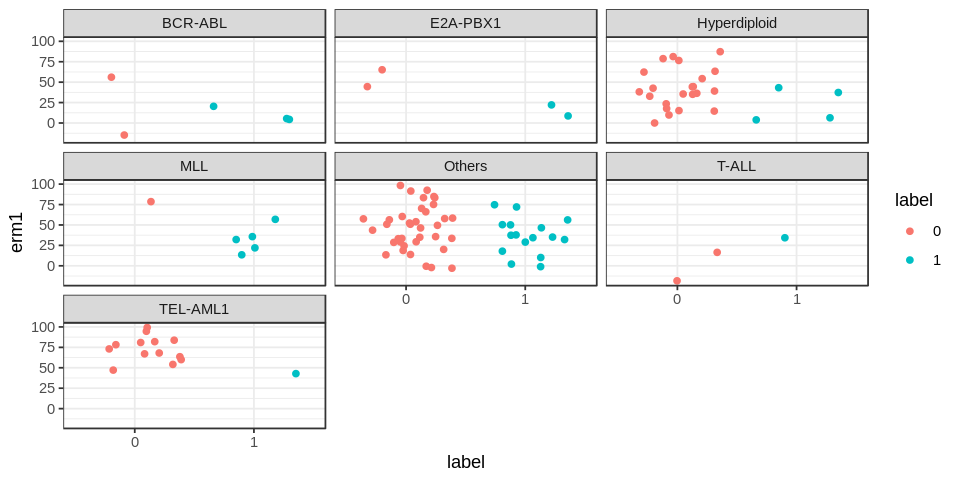

In [441]:
print(threshold)
print(recall)
print(specificity)
global_erm_test1_all2 <- global_erm_test1_all
global_erm_test1_all2$label <- as.factor(global_erm_test1_all2$label)
global_erm_test1_all2$subtype <- yeoh_label[
  rownames(global_erm_test1_all2), "subtype"
]

ggplot(global_erm_test1_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [378]:
# Calculate threshold that maximises recall and specificity
# class(yeoh_label[rownames(global_erm_train2), "label"])
global_erm_train2_y <- data.frame(
  global_erm_train2,
  label = yeoh_label[rownames(global_erm_train2), "label"]
)

roc_obj <- pROC::roc(
  global_erm_train2_y,
  "label",
  "erm1",
  direction = ">"
)
# NOTE: roc function calculates thresholds by taking the 
# arithmetic mean of two adjacent points
roc_thresholds <- data.frame(
  roc_obj$thresholds,
  roc_obj$sensitivities,
  roc_obj$specificities
)
roc_thresholds$mean <- mapply(
  function(x, y) mean(c(x, y)),
  roc_obj$sensitivities,
  roc_obj$specificities
)

Setting levels: control = 0, case = 1


In [395]:
threshold <- roc_thresholds[which.max(roc_thresholds$mean), "roc_obj.thresholds"]

global_erm_test2_all <- data.frame(
  global_erm_test2,
  label = yeoh_label[rownames(global_erm_test2), "label"],
  y_pred = ifelse(global_erm_test2$erm1 < threshold, 1, 0)
)

global_erm_test2_recall <- calc_recall(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
global_erm_test2_specificity <- calc_specificity(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
print(global_erm_test2_recall)
print(global_erm_test2_specificity)

[1] 0.9166667
[1] 0.8


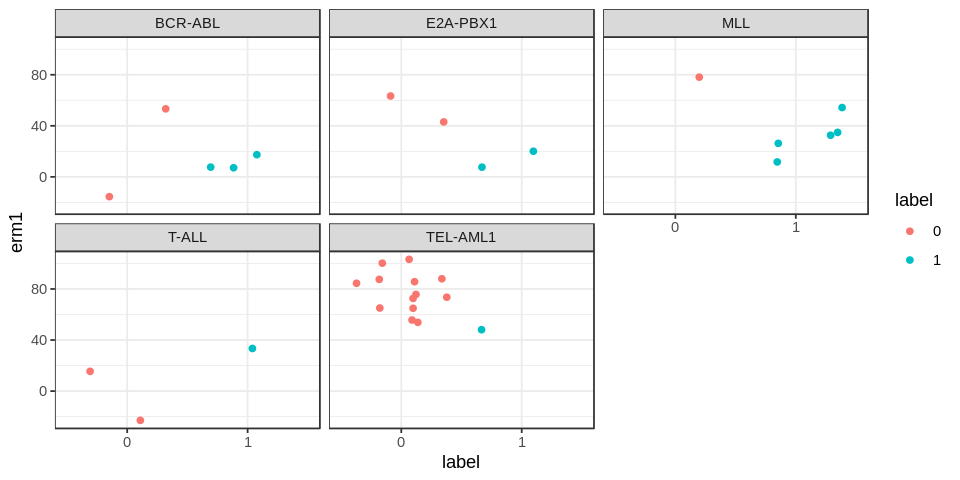

In [443]:
global_erm_test2_all2 <- global_erm_test2_all
global_erm_test2_all2$label <- as.factor(global_erm_test2_all2$label)
global_erm_test2_all2$subtype <- yeoh_label[
  rownames(global_erm_test2_all2), "subtype"
]

ggplot(global_erm_test2_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [374]:
a <- plot_roc(
  aSAH,
  "outcome",
  c("s100b", "ndka"),
  pauc.limits = c(1, 0.6),
  pauc.axis = "sensitivity"
)

Setting levels: control = Good, case = Poor
Setting direction: controls < cases
Setting levels: control = Good, case = Poor
Setting direction: controls < cases


### Plot: Jitter

### Training data (w Hyper, Others)

In [93]:
X_normal <- data[, rownames(Y)[Y$class_info == "N"]]
list_X_subtype1 <- lapply(
  subtypes,
  function(s) data[, rownames(Y)[Y$subtype == s]]
)
list_obj1 <- lapply(
  list_X_subtype1,
  predict_pipeline,
  X_normal, Y, yeoh_label,
  batch_genes
)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of selected genes = " "262"                     
[1] "No. of final genes = " "170"                  
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of selected genes = " "448"                     
[1] "No. of final genes = " "342"                  
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of selected genes = " "80"                      
[1] "No. of final genes = " "66"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8"

Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


In [94]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj1,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_train1
)

In [95]:
#' Plots boxplot of features, p_rem and global ERM
#' Provides p-values of log(mrd), p_rem and global ERM
plot_boxplots <- function(X_y) {
  COL_LABEL <- c("darkolivegreen3", "tomato3")
  FEAT_ORDER <- c(
    "erm1_ratio2", "l2norm_ratio2", "angle_d0d8_d0normal",
    "log_mrd", "global_erm", "p_rem"
  )
  FEAT_LABS <- c(
    "'ERM Ratio'", "'ARM Ratio'", "theta",
    "log[10](MRD)", "'Global ERM'", "paste('P(Remission|', bold(x), ')')"
  )
  
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")

  # Reorder levels and label features
  long_X_y$feature <- factor(
    long_X_y$feature,
    levels = FEAT_ORDER,
    labels = FEAT_LABS
  )
  
  ax_jitter <- ggplot(
    long_X_y,
    aes(x = feature, y = value, colour = label)
  ) +
    geom_boxplot(alpha = 0, show.legend = F) +
    geom_point(position = position_jitterdodge(),
               cex = 2, show.legend = F) +
    scale_color_manual(values = COL_LABEL) +
    facet_wrap(
      ~feature,
      nrow = 1, scales = "free",
      labeller = label_parsed
    ) +
    theme(
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "none"
    )
  
  print(X_y)
  # Jitter plot: p-value label
  # Both group sizes must be > 1
  if (length(table(X_y$label)) > 1 && min(table(X_y$label)) > 1) {
    p_labs <- sapply(
      FEAT_ORDER[4:6],
      function(idx) {
        list_feat <- split(X_y[idx], X_y$label)
        tryCatch({
            ttest <- t.test(list_feat[[1]], list_feat[[2]])
            sprintf("p = %.3f", ttest$p.value)
          },
          error = function(err) {
            return(NA)
          }
        ) 
      }
    )
    
    ann_text <- data.frame(
      feature = factor(
        FEAT_ORDER[4:6],
        levels = FEAT_ORDER,
        labels = FEAT_LABS
      ),
      value = c(
        min(X_y[FEAT_ORDER[4]]),
        max(X_y[FEAT_ORDER[5]]),
        max(X_y[FEAT_ORDER[6]])
      ),
      lab = p_labs
    )
    ann_text <- na.omit(ann_text)

    ax_jitter <- ax_jitter +
      geom_label(data = ann_text,
                  aes(x = feature, y = value, label = lab),
                  size = 3, colour = "black",
                  alpha = 0.5, hjust = 0)
  }
  
  ax_jitter
}

In [306]:
# list_boxplots <- lapply(list_X_y, plot_boxplots)

# for (i in seq_len(length(subtypes))) {
#   wpath <- sprintf("~/Dropbox/temp/features_alltrain-%s.pdf",
#                    subtypes[i])
#   ggsave(wpath, list_boxplots[[i]],
#          width = 10, height = 3)
# }

### Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


### Breakdown of train and test sets

In [960]:
## Breakdown of train and test sets
idx1 <- Y$batch_info %in% 1:5 & Y$class_info == "D0"
idx2 <- !(Y$batch_info %in% 1:5) & Y$class_info == "D0"
Y_train <- Y[idx1,]
Y_test <- Y[idx2,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(xtable(tab_test))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Thu Nov 12 01:34:19 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   2 &   3 \\ 
  E2A-PBX1 &   2 &   2 \\ 
  Hyperdiploid &  22 &   4 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   5 \\ 
  Normal &   0 &   0 \\ 
  Others &  37 &  16 \\ 
  T-ALL &   2 &   1 \\ 
  TEL-AML1 &  13 &   1 \\ 
   \hline
\end{tabular}
\end{table}


#### Relapse prediction (Hyperdiploid)

In [738]:
subtype <- "Hyperdiploid"
wpath1 <- "~/Dropbox/temp/vectors_label-Hyperdiploid.pdf"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
avg_p <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                         batch_genes = batch_genes,
                         wpath1 = wpath1)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


#### Plot x v.s. TPR

In [ ]:
plot_tpr1 <- function(x, name, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  plot(TPR, sort_x, ylab = name, col = col, type = "l")
}


plot_tpr2 <- function(x, col){
  sort_x <- sort(x)
  rank_x <- rank(sort_x, ties.method = "max")
  TPR <- rank_x / length(x)
  lines(TPR, sort_x, col = col, type = "l")
}

cols <- ggplot_palette(4)
features <- c("ERM", "p", "p (w/o MRD)", "-log10(MRD)")

pdf("~/Dropbox/temp/tpr_x.pdf", 6, 6)
plot_tpr1(normaliseMinmax(p_y_sub$erm1), "x", cols[1])
plot_tpr2(p_y_sub$p, cols[2])
plot_tpr2(p_y_sub$p_wo, cols[3])
plot_tpr2(normaliseMinmax(-log10(p_y_sub$d33_mrd)), cols[4])
legend("topleft", legend = features, col = cols, lwd=2)
dev.off()

## Subnetworks

In [8]:
# 1. Removes affymetrix ambiguous and control probesets
# 2. Map probesets to IDs
# Removes one-to-many probesets and probesets with no ID
# Selects maximum if two probesets match to same gene
# CHECK: What microarray platform is the data from?
ENTREZ_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_entrez-GPL570.tsv"
entrez_data <- affy2id(data, ENTREZ_GPL570)

## SYMBOL_GPL570 <- "../info/microarray/HG-U133_Plus_2/annot_genesymbol-GPL570.tsv"
## symbol_yeoh <- affy2id(data_yeoh, SYMBOL_GPL570)

No. of probesets mapping to multiple IDs removed: 223
No. of probesets with no ID removed: 160
Total no. of probesets removed (incl. probesets mapping to same gene): 1128


In [572]:
# Calculate individual D0-N magnitude (normal centroid)
normal <- entrez_data[, startsWith(colnames(entrez_data), "N")]
D0 <- entrez_data[, endsWith(colnames(entrez_data), "D0")]
D8 <- entrez_data[, endsWith(colnames(entrez_data), "D8")]

#### Unfiltered data

In [573]:
raw_data <- log2_transform(selected_yeoh)
araw <- affy2id(raw_data, ENTREZ_GPL570)
lidx1 <- sapply(subnetwork_nea,
                function(ids) all(ids %in% rownames(araw)))
subnetwork2 <- subnetwork_nea[lidx1]
print(length(subnetwork2))
                
# Calculate individual D0-N magnitude (normal centroid)
normal_raw <- araw[, startsWith(colnames(araw), "N")]
D0_raw <- araw[, endsWith(colnames(araw), "D0")]
D8_raw <- araw[, endsWith(colnames(araw), "D8")]

No. of probesets mapping to multiple IDs removed: 412
No. of probesets with no ID removed: 1010
Total no. of probesets removed (incl. probesets mapping to same gene): 4185
[1] 4715


#### Import subnetworks

In [ ]:
## Import NEA subnetworks
NEA_RPATH <- paste0("../diff_expr/data/subnetwork/nea-hsa/",
                    "ovarian_cancer/geneset-nea_kegg_ovarian.tsv")
nea_df <- read.table(NEA_RPATH, sep = "\t", header = T, stringsAsFactors = F)
subnetwork_nea <- split(as.character(nea_df$gene_id), nea_df$subnetwork_id)

In [570]:
# Filter out subnetworks with genes that are missing in the data
lidx <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(entrez_data)))
nea_fltr <- subnetwork_nea[lidx]
               
lidx1 <- sapply(subnetwork_nea,
               function(ids) all(ids %in% rownames(araw)))
nea_unfltr <- subnetwork_nea[lidx1]

In [728]:
print(length(subnetwork_nea))
print(length(nea_unfltr))

[1] 4715
[1] 4715


#### Only half of the KEGG ids are represented in the data

In [539]:
## Import KEGG pathways
KEGG_RPATH <- "../info/KEGG/kegg-human_allpathway_genes.tsv"
kegg_df <- read.table(KEGG_RPATH, sep = "\t", header = T, stringsAsFactors = F)
kegg_df$Pathway <- substring(kegg_df$Pathway, 6)
list_kegg <- split(kegg_df$Entrez.Gene.ID, kegg_df$Pathway)

In [549]:
sum(unique(unlist(list_kegg)) %in% rownames(araw))

[1] 3839

In [551]:
# kegg_size <- sapply(subnetwork_pwapi, length)
# kegg_hit <- sapply(subnetwork_pwapi,
#                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data
incomplete_kegg <- lapply(list_kegg,
                          function(ids) ids[ids %in% rownames(araw)])
kegg_size <- sapply(incomplete_kegg, length)
SIZE <- 5
incomplete_kegg_sub <- incomplete_kegg[kegg_size > SIZE]
kegg_size1 <- sapply(incomplete_kegg_sub, length)

In [417]:
## Import pathwayAPI
PWAPI_RPATH <- "../info/pathwayAPI/pwapi_id_human-filtered_entrez.tsv"
pwapi_df <- read.table(PWAPI_RPATH, sep = "\t", header = T, stringsAsFactors = F)
list_pwapi <- split(pwapi_df[,2:3], pwapi_df$pathway_id)
subnetwork_pwapi <- lapply(list_pwapi,
                           function(X) unique(as.numeric(data.matrix(X))))

In [466]:
pwapi_size <- sapply(subnetwork_pwapi, length)
pwapi_hit <- sapply(subnetwork_pwapi,
                    function(ids) sum(ids %in% rownames(araw)))

## Only include the IDs represented in the data in pathwayAPI
subnetwork_pwapi_sub <- lapply(subnetwork_pwapi,
                                function(ids) ids[ids %in% rownames(araw)])
pwapi_size1 <- sapply(subnetwork_pwapi_sub, length)
SIZE <- 5
subnetwork_pwapi_sub1 <- subnetwork_pwapi_sub[pwapi_size1 > SIZE]
pwapi_size2 <- sapply(subnetwork_pwapi_sub1, length)
print(cbind(pwapi_hit[pwapi_size1 > SIZE], pwapi_size2))

             pwapi_size2
pwapi002  10          10
pwapi003 144         144
pwapi004  36          36
pwapi005  67          67
pwapi006  39          39
pwapi007  43          43
pwapi008  14          14
pwapi012   6           6
pwapi016  11          11
pwapi017  28          28
pwapi018  24          24
pwapi019  23          23
pwapi020  29          29
pwapi021  44          44
pwapi022  55          55
pwapi023   8           8
pwapi024 116         116
pwapi025  30          30
pwapi026  17          17
pwapi029  75          75
pwapi030 139         139
pwapi031  27          27
pwapi032  27          27
pwapi033  27          27
pwapi034  28          28
pwapi036  13          13
pwapi037  22          22
pwapi038  12          12
pwapi040  16          16
pwapi041  18          18
pwapi042  10          10
pwapi044  32          32
pwapi045 108         108
pwapi046  54          54
pwapi048  68          68
pwapi049  32          32
pwapi050  11          11
pwapi051  23          23
pwapi052  28          28


#### Subnetwork deltas (D0-N)
- Comparing variance of subnetwork deltas was not conclusive
- Means of the random sample seem to have a larger proportion of higher mean subnetworks

- Sum of deltas (D0-D8) is not a good feature
- Percentage of sum of deltas is not a good feature
    - Does not take into account the sign of the logfc
    - Does not consider individual subnetwork
- Percentage of each subnetwork
    - Filter out subnetwork that has delta_D0N of less than threshold?

In [571]:
#' @param ids vector of gene IDs belonging to a subnetwork
#' @param X dataframe of expr values at D0
#' @param Y vector or dataframe of expr values at specific timepoint
#' @return vector of deltas of patients of a particular subnetwork
calc_subnetwork_delta <- function(ids, X, Y) {
  if(is.numeric(ids)) # how to handle factor?
    ids <- as.character(ids)
  
  if (is.vector(Y)) {
    logfc <- Y[ids] - X[ids,]
  } else {
    stopifnot(substring(colnames(X),1,4) ==
              substring(colnames(Y),1,4))
    logfc <- Y[ids,] - X[ids,]
  }
  return(colMeans(abs(logfc)))
}

In [651]:
# Plots batches in different colours and classes in different symbols
plotPCA2D <- function(df1, metadata_df, pc_labels = NULL) {
  # Obtaining batch and class annotations
  batch_factor <- as.factor(metadata_df[colnames(df1),"label"])
  class_factor <- metadata_df[colnames(df1), "subtype"]
  print(head(batch_factor))
  print(head(class_factor))
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(df1))
    pca_df <- data.frame(pca_obj$x[,1:4])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(df1)
  }
  
  pc1_pc2 <- ggplot(pca_df, aes(x = PC1, y = PC2, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  # theme(plot.title = element_text(hjust = 0.5))

  pc1_pc3 <- ggplot(pca_df, aes(x = PC1, y = PC3, col = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = F) +
    labs(x = pc_labels[1], y = pc_labels[3]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)

  pca_plot <- plot_grid(pc1_pc2, pc1_pc3)
  
  return(pca_plot)
}

#### Filtered data - NEA

In [574]:
norm_centroid <- rowMeans(normal)

delta_D0N <- data.frame(t(sapply(nea_fltr,
                                 calc_subnetwork_delta,
                                 D0, norm_centroid)))
delta_D0D8 <- data.frame(t(sapply(nea_fltr,
                                  calc_subnetwork_delta,
                                  D0, D8)))

In [658]:
print(length(nea_unfltr))

[1] 4715


[1] "BCR-ABL"
[1] 9


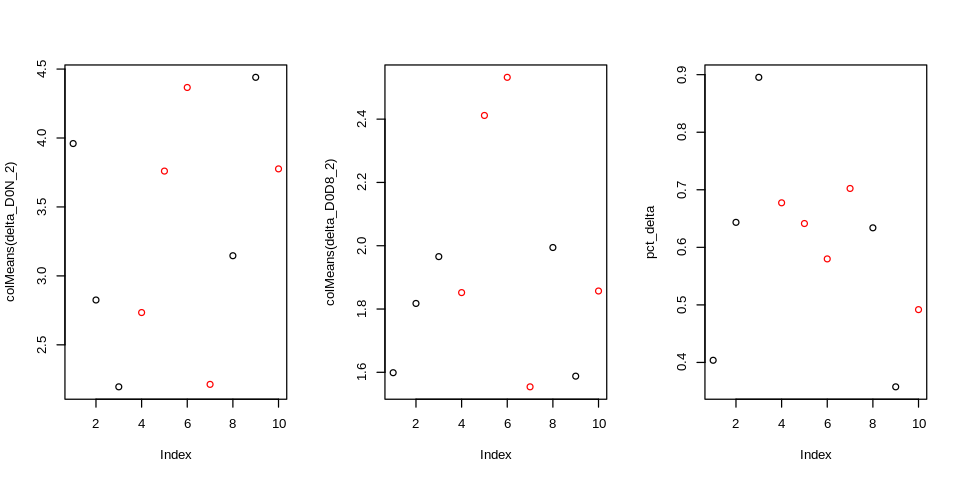

In [669]:
subtype <- subtypes[[1]]
print(subtype)
delta_D0N_1 <- delta_D0N[
  , Y[colnames(delta_D0N), "subtype"] == subtype
]
delta_D0D8_1 <- delta_D0D8[
  , Y[colnames(delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

mu_delta <- apply(delta_D0N_1, 1, mean)
var_delta <- apply(delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)

THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))
delta_D0D8_2 <- delta_D0D8_1[idx_subnetwork, ]
delta_D0N_2 <- delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- colMeans(delta_D0D8_2) / colMeans(delta_D0N_2)

par(mfrow=c(1,3))
plot(colMeans(delta_D0N_2), col = Y[names(pct_delta), "label"] + 1)
plot(colMeans(delta_D0D8_2), col = Y[names(pct_delta), "label"] + 1)
plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

In [662]:
print(colnames(delta_D0D8_1)[Y[colnames(delta_D0D8_1), "label"] == 1])

[1] "P056_D8" "P057_D8" "P134_D8" "P152_D8" "P184_D8"


[1] 0 0 0 0 0 0
Levels: 0 1
[1] TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1 TEL-AML1
9 Levels: BCR-ABL E2A-PBX1 Hyperdiploid Hypodiploid MLL Normal ... TEL-AML1


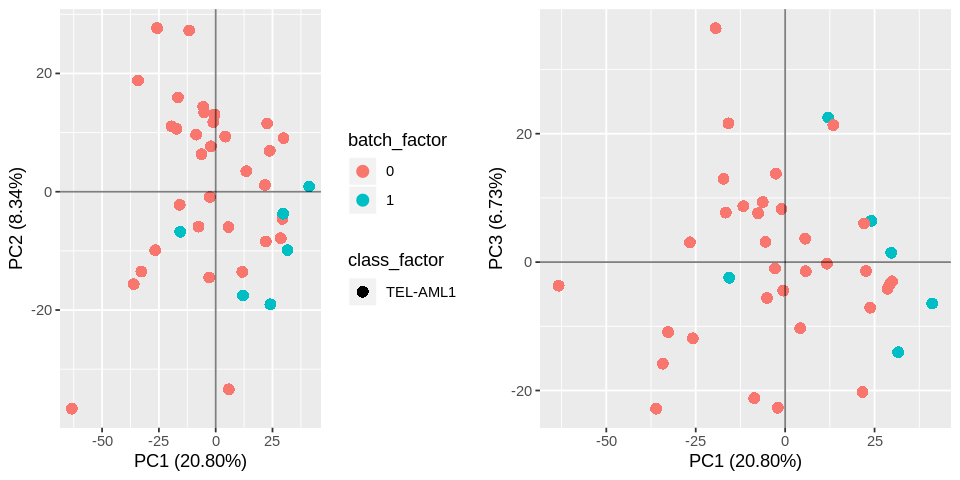

In [653]:
plotPCA2D(raw_delta_D0D8_1, Y)

#### Unfiltered data - NEA

In [641]:
norm_centroid1 <- rowMeans(normal_raw)

raw_delta_D0N <- data.frame(t(sapply(nea_unfltr,
                                 calc_subnetwork_delta,
                                 D0_raw, norm_centroid1)))
raw_delta_D0D8 <- data.frame(t(sapply(nea_unfltr,
                                  calc_subnetwork_delta,
                                  D0_raw, D8_raw)))

In [734]:
for (subtype in subtypes) {
  print(subtype)
  raw_delta_D0N_1 <- raw_delta_D0N[
    , Y[colnames(raw_delta_D0N), "subtype"] == subtype
  ]
  raw_delta_D0D8_1 <- raw_delta_D0D8[
    , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
  ]

  stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
            substring(colnames(raw_delta_D0D8_1),1,4))

  mu_delta <- apply(raw_delta_D0N_1, 1, mean)
  var_delta <- apply(raw_delta_D0N_1, 1, var)
  # plot(mu_delta, var_delta)
  THRESHOLD <- 3
  idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]

  ## Selecting subnetworks with significant dysregulation
  raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
  raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

  # print(colnames(delta_D0D8_1)[
  #   Y[colnames(delta_D0D8_1), "label"] == 1
  # ])

  pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
  
  #   pct_delta_rem <- pct_delta[, Y[colnames(pct_delta), "label"] == 0]
#   mean_pct <- rowMeans(pct_delta_rem)
#   PCT <- 0.7
#   nea_responsive <- names(mean_pct)[mean_pct > PCT]
#   print(length(nea_responsive))
#   pct_delta_responsive <- colMeans(pct_delta[nea_responsive, ])

  fpath <- sprintf("~/Dropbox/temp/delta-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(raw_delta_D0N_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0N)",
       pch = 16, cex = 1.5)
  plot(colMeans(raw_delta_D0D8_2),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(delta_D0D8)",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta),
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "mean(pct_delta)",
       pch = 16, cex = 1.5)
#   plot(pct_delta_responsive,
#        col = Y[names(pct_delta), "label"] + 1,
#        ylab = "mean_responsive(pct_delta)")
  dev.off()
  
  ## Relapse prediction
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  feat <- predict_relapse(pid_subtype, data, pid_remission, Y,
                          batch_genes = batch_genes)  
  
  fpath <- sprintf("~/Dropbox/temp/delta_corr-%s.pdf", subtype)
  pdf(fpath, 7, 3)
  par(mfrow=c(1,3))
  plot(colMeans(pct_delta), feat[, "erm1_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "erm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "l2norm_ratio2"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "l2norm_ratio",
       pch = 16, cex = 1.5)
  plot(colMeans(pct_delta), feat[, "angle_d0d8_normal"],
       col = Y[names(pct_delta), "label"] + 1,
       ylab = "angle_d0d8_normal",
       pch = 16, cex = 1.5)
  dev.off()
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1

In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


#### Unfiltered data - PathwayAPI

In [484]:
norm_centroid1 <- rowMeans(normal_raw)

pwapi_delta_D0N <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
pwapi_delta_D0D8 <- data.frame(t(sapply(subnetwork_pwapi_sub1,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [535]:
subtype <- subtypes[[4]]
print(subtype)
pwapi_delta_D0N_1 <- pwapi_delta_D0N[
  , Y[colnames(pwapi_delta_D0N), "subtype"] == subtype
]
pwapi_delta_D0D8_1 <- pwapi_delta_D0D8[
  , Y[colnames(pwapi_delta_D0D8), "subtype"] == subtype
]

[1] "MLL"


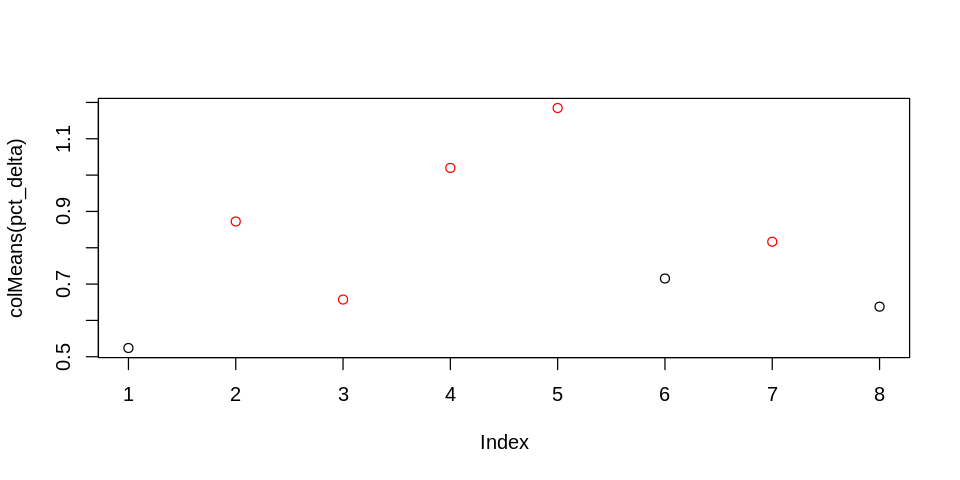

In [536]:
stopifnot(substring(colnames(pwapi_delta_D0N_1),1,4) ==
          substring(colnames(pwapi_delta_D0D8_1),1,4))

pwapi_mu_delta <- apply(pwapi_delta_D0N_1, 1, mean)
pwapi_var_delta <- apply(pwapi_delta_D0N_1, 1, var)
# plot(pwapi_mu_delta, pwapi_var_delta)

THRESHOLD <- 2.5
idx_subnetwork3 <- names(pwapi_mu_delta)[pwapi_mu_delta > THRESHOLD]
pwapi_delta_D0D8_2 <- pwapi_delta_D0D8_1[idx_subnetwork3, ]
pwapi_delta_D0N_2 <- pwapi_delta_D0N_1[idx_subnetwork3, ]

# print(colnames(pwapi_delta_D0D8_1)[
#   Y[colnames(pwapi_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- pwapi_delta_D0D8_2 / pwapi_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Unfiltered data - KEGG

In [552]:
norm_centroid1 <- rowMeans(normal_raw)

kegg_delta_D0N <- data.frame(t(sapply(incomplete_kegg_sub,
                                       calc_subnetwork_delta,
                                       D0_raw, norm_centroid1)))
kegg_delta_D0D8 <- data.frame(t(sapply(incomplete_kegg_sub,
                                        calc_subnetwork_delta,
                                        D0_raw, D8_raw)))

In [566]:
subtype <- subtypes[[7]]
print(subtype)
kegg_delta_D0N_1 <- kegg_delta_D0N[
  , Y[colnames(kegg_delta_D0N), "subtype"] == subtype
]
kegg_delta_D0D8_1 <- kegg_delta_D0D8[
  , Y[colnames(kegg_delta_D0D8), "subtype"] == subtype
]

[1] "TEL-AML1"


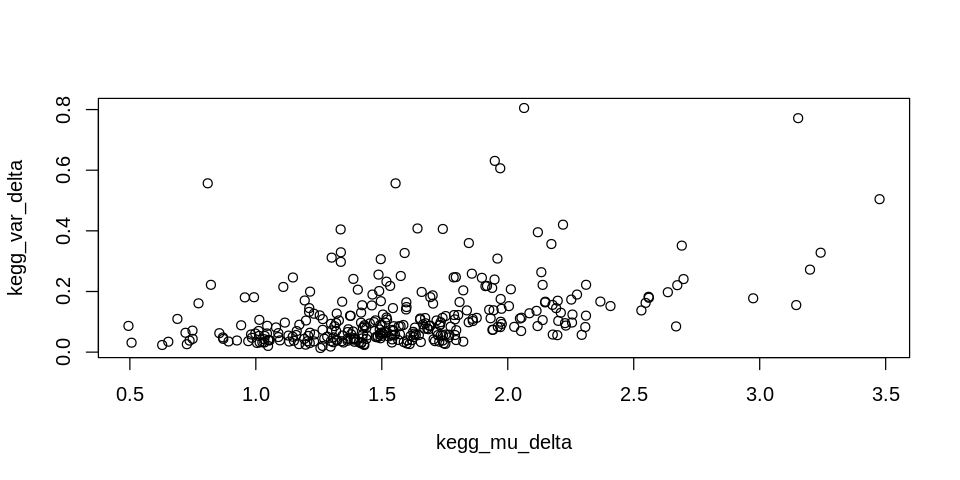

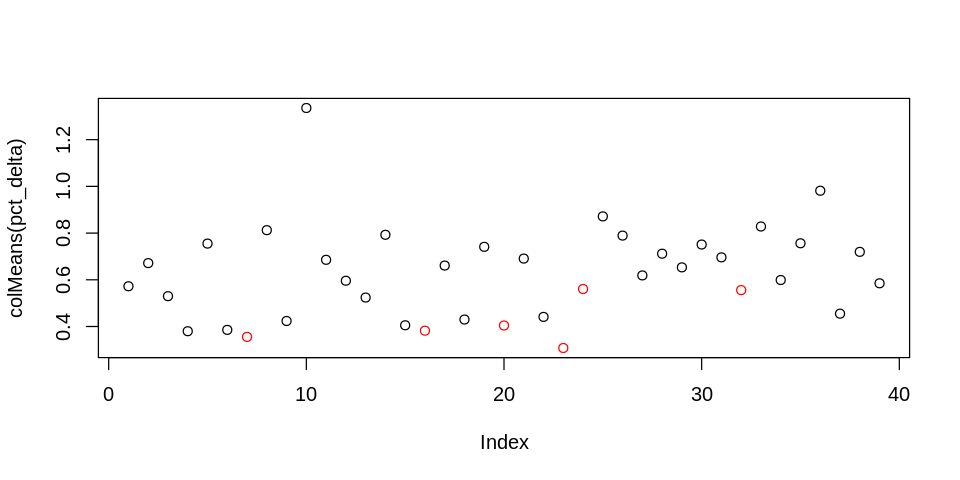

In [567]:
stopifnot(substring(colnames(kegg_delta_D0N_1),1,4) ==
          substring(colnames(kegg_delta_D0D8_1),1,4))

kegg_mu_delta <- apply(kegg_delta_D0N_1, 1, mean)
kegg_var_delta <- apply(kegg_delta_D0N_1, 1, var)
plot(kegg_mu_delta, kegg_var_delta)

THRESHOLD <- 2
idx_subnetwork4 <- names(kegg_mu_delta)[kegg_mu_delta > THRESHOLD]
kegg_delta_D0D8_2 <- kegg_delta_D0D8_1[idx_subnetwork4, ]
kegg_delta_D0N_2 <- kegg_delta_D0N_1[idx_subnetwork4, ]

# print(colnames(kegg_delta_D0D8_1)[
#   Y[colnames(kegg_delta_D0D8_1), "label"] == 1
# ])

pct_delta <- kegg_delta_D0D8_2 / kegg_delta_D0N_2

plot(colMeans(pct_delta), col = Y[names(pct_delta), "label"] + 1)

#### Misc

In [49]:
## Distribution of subnetwork sizes
subnetwork_sizes <- sapply(subnetwork_nea, length)
print(table(subnetwork_sizes))

## Representation of gene IDs in data
all_ids <- unlist(subnetwork_nea)
print(head(sort(names(table(all_ids)))))
print(head(sort(rownames(entrez_data))))

[1] "10"        "100"       "10000"     "10010"     "100131827" "10014"    
[1] "100"       "10000"     "10001"     "10005"     "10010"     "100127972"


In [736]:
dim(data)

[1] 5453  405

#### Data
- 405 samples (201 D0, 201 D8,3 N)
- Originally 210 patients
- Removed 2 outliers, 7 different batches

In [747]:
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")

[1] "P001_D0"  "P004_D0"  "P005_D0"  "P007_D0"  "P008_D0"  "P009_D0" 
  [7] "P010_D0"  "P011_D0"  "P012_D0"  "P013_D0"  "P014_D0"  "P015_D0" 
 [13] "P016_D0"  "P017_D0"  "P018_D0"  "P019_D0"  "P020_D0"  "P022_D0" 
 [19] "P023_D0"  "P024_D0"  "P025_D0"  "P026_D0"  "P027_D0"  "P028_D0" 
 [25] "P029_D0"  "P031_D0"  "P032_D0"  "P033_D0"  "P034_D0"  "P035_D0" 
 [31] "P036_D0"  "P037_D0"  "P038_D0"  "P039_D0"  "P040_D0"  "P041_D0" 
 [37] "P042_D0"  "P043_D0"  "P044_D0"  "P046_D0"  "P047_D0"  "P048_D0" 
 [43] "P049_D0"  "P050_D0"  "P051_D0"  "P053_D0"  "P054_D0"  "P055_D0" 
 [49] "P056_D0"  "P057_D0"  "P058_D0"  "P059_D0"  "P060_D0"  "P061_D0" 
 [55] "P062_D0"  "P063_D0"  "P064_D0"  "P065_D0"  "P066_D0"  "P067_D0" 
 [61] "P068_D0"  "P070_D0"  "P071_D0"  "P072_D0"  "P073_D0"  "P075_D0" 
 [67] "P076_D0"  "P077_D0"  "P078_D0"  "P080_D0"  "P081_D0"  "P082_D0" 
 [73] "P083_D0"  "P084_D0"  "P085_D0"  "P086_D0"  "P087_D0"  "P088_D0" 
 [79] "P089_D0"  "P090_D0"  "P091_D0"  "P092_D0"  "P093_D0"  "P094_D0" 
 [85] "P095_D0"  "P096_D0"  "P097_D0"  "P098_D0"  "P099_D0"  "P100_D0" 
 [91] "P101_D0"  "P102_D0"  "P103_D0"  "P104_D0"  "P105_D0"  "P106_D0" 
 [97] "P107_D0"  "P108_D0"  "P109_D0"  "P110_D0"  "P111_D0"  "P112_D0" 
[103] "P113_D0"  "P114_D0"  "P115_D0"  "P116_D0"  "P117_D0"  "P118_D0" 
[109] "P119_D0"  "P120_D0"  "P121_D0"  "P122_D0"  "P123_D0"  "P124_D0" 
[115] "P125_D0"  "P126_D0"  "P127_D0"  "P128_D0"  "P129_D0"  "P130_D0" 
[121] "P131_D0"  "P132_D0"  "P133_D0"  "P134_D0"  "P135_D0"  "P136_D0" 
[127] "P137_D0"  "P138_D0"  "P139_D0"  "P140_D0"  "P141_D0"  "P142_D0" 
[133] "P143_D0"  "P144_D0"  "P145_D0"  "P146_D0"  "P147_D0"  "P148_D0" 
[139] "P149_D0"  "P150_D0"  "P151_D0"  "P152_D0"  "P153_D0"  "P154_D0" 
[145] "P155_D0"  "P156_D0"  "P157_D0"  "P158_D0"  "P159_D0"  "P160_D0" 
[151] "P161_D0"  "P162_D0"  "P163_D0"  "P164_D0"  "P165_D0"  "P166_D0" 
[157] "P167_D0"  "P168_D0"  "P169_D0"  "P170_D0"  "P171_D0"  "P172_D0" 
[163] "P173_D0"  "P174_D0"  "P175_D0"  "P176_D0"  "P177_D0"  "P178_D0" 
[169] "P179_D0"  "P180_D0"  "P181_D0"  "P182_D0"  "P183_D0"  "P184_D0" 
[175] "P185_D0"  "P187_D0"  "P188_D0"  "P189_D0"  "P190_D0"  "P191_D0" 
[181] "P192_D0"  "P193_D0"  "P194_D0"  "P195_D0"  "P196_D0"  "P197_D0" 
[187] "P199_D0"  "P200_D0"  "P201_D0"  "P202_D0"  "P203_D0"  "P204_D0" 
[193] "P205_D0"  "P206_D0"  "P207_D0"  "P208_D0"  "P209_D0"  "P210_D0" 
[199] "P211_D0"  "P212_D0"  "P213_D0"  "P214_D0"  "P215_D0"  "P216_D0" 
[205] "P217_D0"  "P218_D0"  "P219_D0"  "P220_D0"  "P001_D8"  "P004_D8" 
[211] "P005_D8"  "P007_D8"  "P008_D8"  "P009_D8"  "P010_D8"  "P011_D8" 
[217] "P012_D8"  "P013_D8"  "P014_D8"  "P015_D8"  "P016_D8"  "P017_D8" 
[223] "P018_D8"  "P019_D8"  "P020_D8"  "P022_D8"  "P023_D8"  "P024_D8" 
[229] "P025_D8"  "P026_D8"  "P027_D8"  "P028_D8"  "P029_D8"  "P031_D8" 
[235] "P032_D8"  "P033_D8"  "P034_D8"  "P035_D8"  "P036_D8"  "P037_D8" 
[241] "P038_D8"  "P039_D8"  "P040_D8"  "P041_D8"  "P042_D8"  "P043_D8" 
[247] "P044_D8"  "P046_D8"  "P047_D8"  "P048_D8"  "P049_D8"  "P050_D8" 
[253] "P051_D8"  "P053_D8"  "P054_D8"  "P055_D8"  "P056_D8"  "P057_D8" 
[259] "P058_D8"  "P059_D8"  "P060_D8"  "P061_D8"  "P062_D8"  "P063_D8" 
[265] "P064_D8"  "P065_D8"  "P066_D8"  "P067_D8"  "P068_D8"  "P070_D8" 
[271] "P071_D8"  "P072_D8"  "P073_D8"  "P075_D8"  "P076_D8"  "P077_D8" 
[277] "P078_D8"  "P080_D8"  "P081_D8"  "P082_D8"  "P083_D8"  "P084_D8" 
[283] "P085_D8"  "P086_D8"  "P087_D8"  "P088_D8"  "P089_D8"  "P090_D8" 
[289] "P091_D8"  "P092_D8"  "P093_D8"  "P094_D8"  "P095_D8"  "P096_D8" 
[295] "P097_D8"  "P098_D8"  "P099_D8"  "P100_D8"  "P101_D8"  "P102_D8" 
[301] "P103_D8"  "P104_D8"  "P105_D8"  "P106_D8"  "P107_D8"  "P108_D8" 
[307] "P109_D8"  "P110_D8"  "P111_D8"  "P112_D8"  "P113_D8"  "P114_D8" 
[313] "P115_D8"  "P116_D8"  "P117_D8"  "P118_D8"  "P119_D8"  "P120_D8" 
[319] "P121_D8"  "P122_D8"  "P123_D8"  "P124_D8"  "P125_D8"  "P126_D8" 
[325] "P127_D8"  "P128_D8"  "P129_D8"  "P130_D8"  "P131_D8"  "P132_D8" 
[331] "P133_D8"  "P134_D8"  "P135_D8"  "P1